Intentando cargar el archivo desde: /Users/edusant/Desktop/personal/blue_tab/proyecto-riesgo-crediticio/data/raw/default_of_credit_card_clients.xls
Dataset cargado exitosamente.


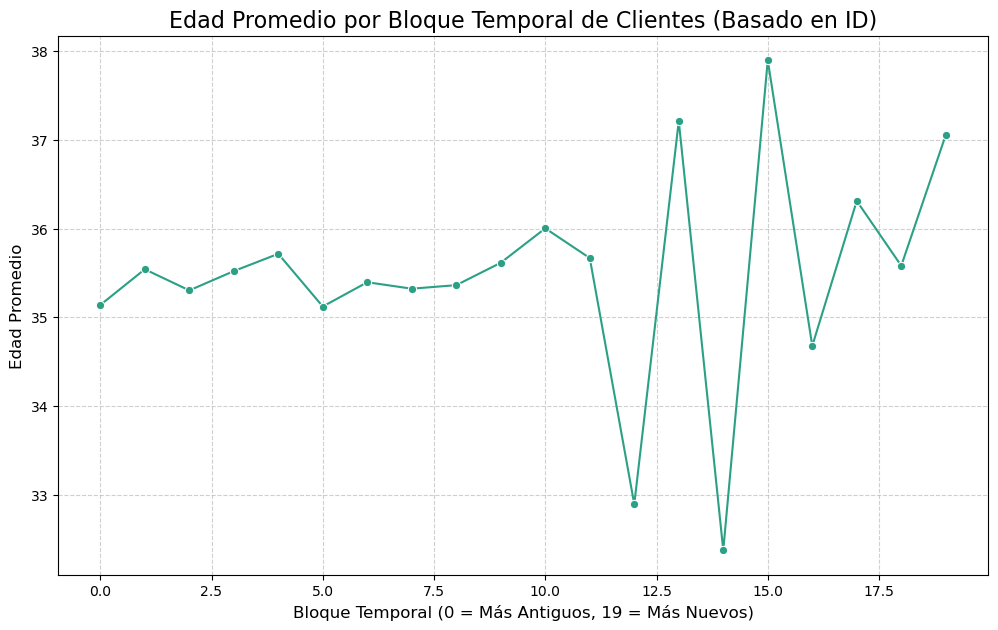

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import spearmanr, kendalltau

try:
    project_root = Path.cwd() 
    raw_data_path = project_root / "data" / "raw" / "default_of_credit_card_clients.xls"
    
    print(f"Intentando cargar el archivo desde: {raw_data_path}")
    
    df = pd.read_excel(raw_data_path, skiprows=1)
    # Renombrar columnas clave para consistencia
    df.rename(columns={'AGE': 'age'}, inplace=True)
    print("Dataset cargado exitosamente.")

except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta esperada: {raw_data_path}")
    print("Asegúrate de que la estructura de directorios es correcta o ajusta la ruta.")
    df = None

if df is not None:
    # 1. Crear 20 "bloques" de tiempo (quantiles) basados en el ID
    # Esto agrupa a los clientes desde los más "antiguos" (quantile 0) a los más "nuevos" (quantile 19)
    df['id_quantile'] = pd.qcut(df['ID'], q=20, labels=False, duplicates='drop')

    # 2. Agrupar por estos bloques y calcular la edad promedio para cada uno
    mean_age_by_id = df.groupby('id_quantile')['age'].mean()

    plt.figure(figsize=(12, 7))
    sns.lineplot(x=mean_age_by_id.index, y=mean_age_by_id.values, marker='o', color='#2ba085')
    plt.title('Edad Promedio por Bloque Temporal de Clientes (Basado en ID)', fontsize=16)
    plt.xlabel('Bloque Temporal (0 = Más Antiguos, 19 = Más Nuevos)', fontsize=12)
    plt.ylabel('Edad Promedio', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   age                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [ ]:

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_cols = [
    col for col in df.columns
    if col not in ['ID', 'default payment next month', 'id_quantile']
]
y_col = 'default payment next month'

# ——— A) Split por percentiles de ID ———
train_id, test_id = train_test_split(df, test_size=0.2, shuffle=False)
model = RandomForestClassifier()
model.fit(train_id[X_cols], train_id[y_col])
auc_id = roc_auc_score(
    test_id[y_col],
    model.predict_proba(test_id[X_cols])[:, 1]
)
print(f"AUC split por ID: {auc_id:.3f}")

# ——— Preparar df_long para split temporal ———
temporal_vars = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
id_vars = ['ID', y_col] + [col for col in X_cols if col not in temporal_vars]

df_long = df.melt(
    id_vars=id_vars,
    value_vars=temporal_vars,
    var_name='month',
    value_name='pay_status'
)
df_long['month_num'] = df_long['month'].str.extract(r'PAY_(\d+)').astype(int)

# ——— Definir características para el conjunto largo ———
features_long = [col for col in X_cols if col not in temporal_vars] + ['pay_status', 'month_num']

# ——— B) Split por ventana temporal en month_num ———
tscv = TimeSeriesSplit(n_splits=5)
aucs_ts = []

for train_idx, test_idx in tscv.split(df_long, df_long[y_col], groups=df_long['ID']):
    model.fit(
        df_long.iloc[train_idx][features_long],
        df_long.iloc[train_idx][y_col]
    )
    aucs_ts.append(
        roc_auc_score(
            df_long.iloc[test_idx][y_col],
            model.predict_proba(df_long.iloc[test_idx][features_long])[:, 1]
        )
    )

print(f"AUC split temporal (media CV): {sum(aucs_ts)/len(aucs_ts):.3f}")


AUC split por ID: 0.775


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


AUC split temporal (media CV): 0.992


In [ ]:
import ruptures as rpt

# Serie a analizar
serie = df.groupby('id_quantile')['age'].mean().values

# Algoritmo PELT con modelo de cambio de media
algo = rpt.Pelt(model="l2").fit(serie)
breaks = algo.predict(pen=3)  
print(f"Puntos de cambio detectados en bloques: {breaks}")


Puntos de cambio detectados en bloques: [15, 20]
